# SECCIÓN 1: Instalación de Dependencias

In [ ]:
!pip install roboflow tensorflow matplotlib scikit-learn pandas opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


# SECCIÓN 2: Importaciones y Configuración Inicial

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from roboflow import Roboflow

# Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Parámetros globales
img_height, img_width = 224, 224
batch_size = 32

# SECCIÓN 3: Descarga del Dataset desde Roboflow

In [ ]:
rf = Roboflow(api_key="VBAQRpw9273AXkedUZfd")
project = rf.workspace("coralreef").project("coral-reef-bleach-detection")
version = project.version(2)

try:
    dataset = version.download("multiclass")
except Exception as e:
    print(f"Error during Roboflow download, assuming dataset is already present: {e}")
    dataset_name = project.name.replace(" ", "-")
    dataset_version = version.version
    dataset_location_guess = os.path.join(os.getcwd(), dataset_name, dataset_version)
    print(f"Attempting to use dataset location: {dataset_location_guess}")
    if os.path.exists(dataset_location_guess):
        dataset = type('obj', (object,), {'location': dataset_location_guess})()
        print("Using guessed dataset location.")
    else:
        raise FileNotFoundError(f"Could not find dataset at {dataset_location_guess} after download attempt failed.") from e

print(f"Dataset path: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Coral-Reef-Bleach-Detection-2 in multiclass:: 100%|██████████| 10789/10789 [00:02<00:00, 3608.15it/s]


Dataset path: /content/Coral-Reef-Bleach-Detection-2


# SECCIÓN 4: Exploración de Directorios y Verificación de CSV

In [ ]:
def check_image_paths(directory):
    print(f"Checking {directory}...")
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', 'tiff']
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))
    print(f"Found {len(image_paths)} images in {directory}")
    if image_paths:
        print(f"Example paths: {image_paths[:3]}")
    return image_paths

# Directorios base
train_dir = os.path.join(dataset.location, 'train')
valid_dir = os.path.join(dataset.location, 'valid')
test_dir = os.path.join(dataset.location, 'test')

# Exploramos imágenes
print("\nChecking image directories...")
train_images = check_image_paths(train_dir)
valid_images = check_image_paths(valid_dir)
test_images = check_image_paths(test_dir)

# Verificamos existencia de archivos CSV
train_csv = os.path.join(train_dir, '_classes.csv')
valid_csv = os.path.join(valid_dir, '_classes.csv')
test_csv = os.path.join(test_dir, '_classes.csv')

print(f"\nTrain CSV exists: {os.path.exists(train_csv)}")
print(f"Valid CSV exists: {os.path.exists(valid_csv)}")
print(f"Test CSV exists: {os.path.exists(test_csv)}")


Checking image directories...
Checking /content/Coral-Reef-Bleach-Detection-2/train...
Found 10044 images in /content/Coral-Reef-Bleach-Detection-2/train
Example paths: ['/content/Coral-Reef-Bleach-Detection-2/train/youtube-1019_jpg.rf.64d81f9775a63fcdc7da53576535f483.jpg', '/content/Coral-Reef-Bleach-Detection-2/train/youtube-36_jpg.rf.8c301e473e8d6091fd941bc3bd5e35ab.jpg', '/content/Coral-Reef-Bleach-Detection-2/train/youtube-73_jpg.rf.093b23063a2cc4c1e0abf4c6816c6eab.jpg']
Checking /content/Coral-Reef-Bleach-Detection-2/valid...
Found 474 images in /content/Coral-Reef-Bleach-Detection-2/valid
Example paths: ['/content/Coral-Reef-Bleach-Detection-2/valid/youtube-175_jpg.rf.bbde2614733588143e093cf6e9eb8dd4.jpg', '/content/Coral-Reef-Bleach-Detection-2/valid/youtube-67_jpg.rf.362552bffb797cb25dda94fb91b4f8ca.jpg', '/content/Coral-Reef-Bleach-Detection-2/valid/frame_29880_jpg.rf.2677fc6e400546119cdef8abb0dda23f.jpg']
Checking /content/Coral-Reef-Bleach-Detection-2/test...
Found 263 ima

# SECCIÓN 5: Función para Cargar Datos desde CSV

In [ ]:
def load_dataset_from_csv(csv_path, images_dir):
    df = pd.read_csv(csv_path)

    column_names = df.columns.tolist()
    filename_col = None
    class_col = None
    filename_patterns = ['file', 'image', 'path', 'name', 'filename']
    class_patterns = ['class', 'label', 'category', 'annotation']

    for col in column_names:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in filename_patterns) and filename_col is None:
            filename_col = col
        elif any(pattern in col_lower for pattern in class_patterns) and class_col is None:
            class_col = col

    if filename_col is None and len(column_names) >= 1:
        filename_col = column_names[0]
    if class_col is None and len(column_names) >= 2:
        class_col = column_names[1]

    dataset_df = pd.DataFrame()
    dataset_df['filepath'] = df[filename_col].apply(lambda x: os.path.join(images_dir, str(x)))
    dataset_df['class'] = df[class_col].astype(str)

    class_names = sorted(dataset_df['class'].unique())
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}
    dataset_df['class_idx'] = dataset_df['class'].map(class_to_idx)

    dataset_df = dataset_df[dataset_df['filepath'].apply(os.path.exists)].copy()
    return dataset_df, class_names, class_to_idx

#SECCIÓN 6: Generador de Datos Personalizado

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, class_to_idx, batch_size=32, img_size=(224, 224),
                 shuffle=True, augment=False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.class_to_idx = class_to_idx
        self.n_classes = len(class_to_idx)
        self.indexes = np.arange(len(dataframe))
        self.on_epoch_end()

        if augment:
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = None

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]

        batch_x = np.zeros((len(batch_df), *self.img_size, 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_df), self.n_classes), dtype=np.float32)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img = load_img(row['filepath'], target_size=self.img_size)
            img_array = img_to_array(img) / 255.0
            if self.augment and self.datagen:
                img_array = self.datagen.random_transform(img_array)
            batch_x[i] = img_array
            batch_y[i] = to_categorical(row['class_idx'], num_classes=self.n_classes)

        return batch_x, batch_y

# Carga de datos y configuración de generadores

print("\n--- Cargando datos del CSV con DataGenerator personalizado ---")
using_csv_generator = False

try:
    train_df, class_names, class_to_idx = load_dataset_from_csv(train_csv, train_dir)
    valid_df, _, _ = load_dataset_from_csv(valid_csv, valid_dir)
    test_df, _, _ = load_dataset_from_csv(test_csv, test_dir)

    if len(train_df) > 0 and len(valid_df) > 0 and len(test_df) > 0:
        train_generator = DataGenerator(train_df, class_to_idx, batch_size=batch_size,
                                        img_size=(img_height, img_width), augment=True)
        validation_generator = DataGenerator(valid_df, class_to_idx, batch_size=batch_size,
                                             img_size=(img_height, img_width), shuffle=False)
        test_generator = DataGenerator(test_df, class_to_idx, batch_size=batch_size,
                                       img_size=(img_height, img_width), shuffle=False)

        using_csv_generator = True
        print("✅ Generadores cargados correctamente desde CSV.")
    else:
        raise ValueError("Los archivos CSV están vacíos o incompletos.")

except Exception as e:
    print(f"❌ Error cargando desde CSV: {e}")
    print("⚠️ Usando alternativa: flow_from_directory con ImageDataGenerator")

    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    validation_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    using_csv_generator = False

# Definición de class_names y num_classes

if using_csv_generator:
    class_names = sorted(train_df['class'].unique())
else:
    class_names = list(train_generator.class_indices.keys())

num_classes = len(class_names)

print(f"\nClases detectadas: {class_names}")
print(f"Número total de clases: {num_classes}")


--- Cargando datos del CSV con DataGenerator personalizado ---
✅ Generadores cargados correctamente desde CSV.

Clases detectadas: ['0', '1']
Número total de clases: 2


# SECCIÓN 7: Construcción del Modelo (Transfer Learning con VGG16)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,828,034 (106.16 MB)

 Trainable params: 13,111,298 (50.02 MB)

 Non-trainable params: 14,716,736 (56.14 MB)

# SECCIÓN 8: Entrenamiento del Modelo

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping, checkpoint_cb, reduce_lr]
)

model.save('final_model_vgg16.h5')

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7484 - loss: 0.6708

314/314 ━━━━━━━━━━━━━━━━━━━━ 197s 583ms/step - accuracy: 0.7486 - loss: 0.6702 - val_accuracy: 0.9051 - val_loss: 0.2359 - learning_rate: 1.0000e-04
Epoch 2/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8647 - loss: 0.3676

314/314 ━━━━━━━━━━━━━━━━━━━━ 153s 486ms/step - accuracy: 0.8647 - loss: 0.3676 - val_accuracy: 0.9346 - val_loss: 0.2061 - learning_rate: 1.0000e-04
Epoch 3/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 483ms/step - accuracy: 0.8772 - loss: 0.3312 - val_accuracy: 0.9304 - val_loss: 0.2062 - learning_rate: 1.0000e-04
Epoch 4/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 153s 487ms/step - accuracy: 0.8870 - loss: 0.3118 - val_accuracy: 0.9283 - val_loss: 0.1939 - learning_rate: 1.0000e-04
Epoch 5/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 482ms/step - accuracy: 0.8959 - loss: 0.2755 - val_accuracy: 0.9325 - val_loss: 0.1798 - learning_rate: 1.0000e-04
Epoch 6/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 482ms/step - accuracy: 0.9119 - loss: 0.2385 - val_accuracy: 0.9219 - val_loss: 0.1968 - learning_rate: 1.0000e-04
Epoch 7/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 480ms/step - accuracy: 0.9174 - loss: 0.2213 - val_accuracy: 0.9241 - val_loss: 0.1751 - learning_rate: 1.0000e-04
Epoch 8/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/st

314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.9148 - loss: 0.2192 - val_accuracy: 0.9451 - val_loss: 0.1561 - learning_rate: 1.0000e-04
Epoch 9/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 482ms/step - accuracy: 0.9212 - loss: 0.2049 - val_accuracy: 0.9451 - val_loss: 0.1586 - learning_rate: 1.0000e-04
Epoch 10/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9206 - loss: 0.1937

314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 484ms/step - accuracy: 0.9206 - loss: 0.1937 - val_accuracy: 0.9536 - val_loss: 0.1543 - learning_rate: 1.0000e-04
Epoch 11/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 150s 479ms/step - accuracy: 0.9285 - loss: 0.1931 - val_accuracy: 0.9494 - val_loss: 0.1524 - learning_rate: 1.0000e-04
Epoch 12/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.9292 - loss: 0.1806 - val_accuracy: 0.9536 - val_loss: 0.1513 - learning_rate: 1.0000e-04
Epoch 13/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 483ms/step - accuracy: 0.9317 - loss: 0.1712 - val_accuracy: 0.9473 - val_loss: 0.1459 - learning_rate: 1.0000e-04
Epoch 14/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 482ms/step - accuracy: 0.9336 - loss: 0.1740 - val_accuracy: 0.9430 - val_loss: 0.1580 - learning_rate: 1.0000e-04
Epoch 15/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 484ms/step - accuracy: 0.9364 - loss: 0.1650 - val_accuracy: 0.9473 - val_loss: 0.1513 - learning_rate: 1.0000e-04


# SECCIÓN 9: Evaluación y Resultados

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.9475 - loss: 0.1274
Test accuracy: 0.9392
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       122
           1       0.93      0.96      0.94       141

    accuracy                           0.94       263
   macro avg       0.94      0.94      0.94       263
weighted avg       0.94      0.94      0.94       263



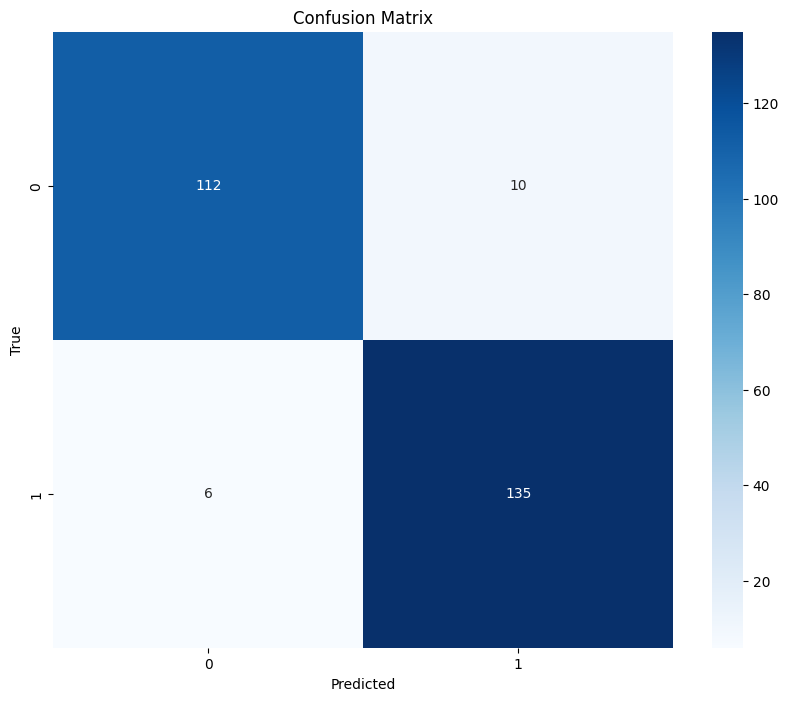

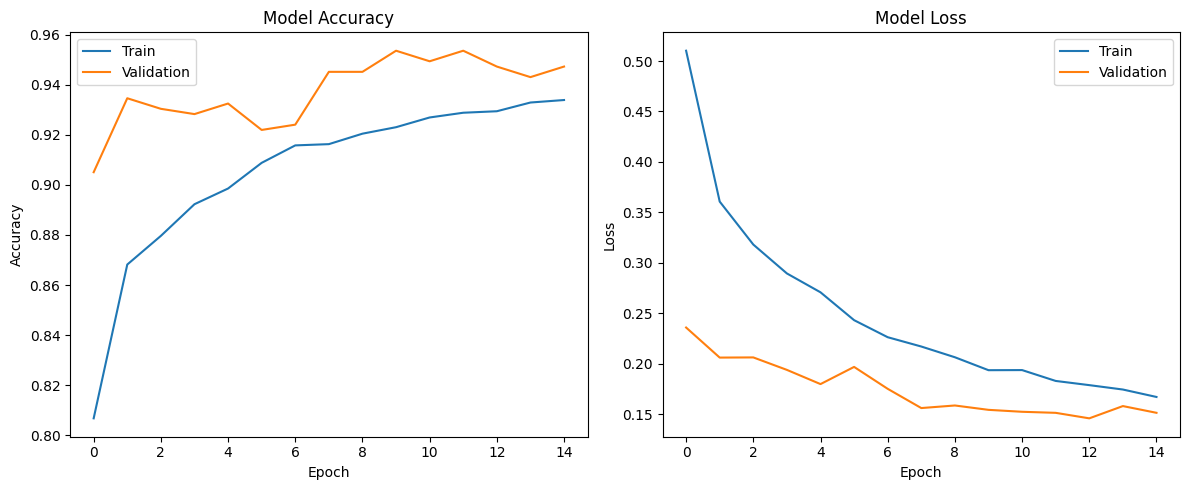

In [ ]:
import seaborn as sns

# Evaluación
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

# Recopilar predicciones
y_true, y_pred = [], []
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Reporte de clasificación
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curvas de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

# SECCIÓN 10: Predicción en Nuevas Imágenes

In [ ]:
def predict_coral_image(image_path, model):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    return {
        'class': class_names[predicted_class],
        'confidence': float(prediction[0][predicted_class]),
        'all_probabilities': {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}
    }

# SECCIÓN 11: Interpretabilidad Adicional con LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/s

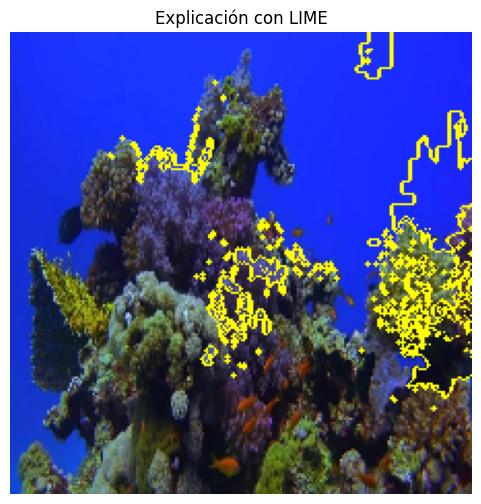

In [ ]:
# Instalación de LIME
!pip install lime --quiet

from lime import lime_image
from skimage.segmentation import mark_boundaries

# Creamos el explicador de imágenes LIME
explainer = lime_image.LimeImageExplainer()

# Función auxiliar para predecir en el formato que espera LIME
def predict_fn(images):
    images = np.array(images) / 255.0
    return model.predict(images)

# Selección de una imagen para explicación (puedes cambiar el índice si deseas otra)
selected_index = 0
if using_csv_generator:
    selected_image_path = test_df['filepath'].iloc[selected_index]
else:
    selected_image_path = test_generator.filepaths[selected_index]

# Carga y preprocesamiento de la imagen
img = load_img(selected_image_path, target_size=(img_height, img_width))
img_array = img_to_array(img).astype('double')

# Aplicación de LIME
explanation = explainer.explain_instance(
    image=img_array,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Visualización del resultado
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.figure(figsize=(6, 6))
plt.title("Explicación con LIME")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()
